# Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
working_directory = 'GitHub/dl-superresolution-ipynb'
%cd /content/drive/MyDrive/$working_directory
!git status

In [ ]:
%pip install -r requirements.txt

## Git Management


In [ ]:
!git config --global user.email "e11909390@student.tuwien.ac.at"
!git config --global user.name "Lollobin"

In [ ]:
!git pull

In [ ]:
!git status

In [ ]:
!git commit -a -m "added connection for google colab"

In [ ]:
!git push

# Preparation


## Data Preprocessing

Generate patches for training and low res images for validation and testing.


### Patch Generation


In [ ]:
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
import patchify
import numpy as np
import matplotlib.gridspec as gridspec
import glob as glob
import os
import cv2

SHOW_PATCHES = False
STRIDE = 14
SIZE = 32

def show_patches(patches):
    plt.figure(figsize=(patches.shape[0], patches.shape[1]))
    gs = gridspec.GridSpec(patches.shape[0], patches.shape[1])
    gs.update(wspace=0.01, hspace=0.02)
    counter = 0
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            ax = plt.subplot(gs[counter])
            plt.imshow(patches[i, j, 0, :, :, :])
            plt.axis('off')
            counter += 1
    plt.show()

def create_patches(
    input_paths, out_hr_path, out_lr_path,
):
    os.makedirs(out_hr_path, exist_ok=True)
    os.makedirs(out_lr_path, exist_ok=True)
    all_paths = []
    for input_path in input_paths:
        all_paths.extend(glob.glob(f"{input_path}/*"))
    print(f"Creating patches for {len(all_paths)} images")
    for image_path in tqdm(all_paths, total=len(all_paths)):
        image = Image.open(image_path)
        image_name = image_path.split(os.path.sep)[-1].split('.')[0]
        w, h = image.size
        # Create patches of size (32, 32, 3)
        patches = patchify.patchify(np.array(image), (32, 32, 3), STRIDE)
        if SHOW_PATCHES:
            show_patches(patches)
        counter = 0
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                counter += 1
                patch = patches[i, j, 0, :, :, :]
                patch = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
                cv2.imwrite(
                    f"{out_hr_path}/{image_name}_{counter}.png",
                    patch
                )
                # Convert to bicubic and save.
                h, w, _ = patch.shape
                low_res_img = cv2.resize(patch, (int(w*0.5), int(h*0.5)),
                                        interpolation=cv2.INTER_CUBIC)
                # Now upscale using BICUBIC.
                high_res_upscale = cv2.resize(low_res_img, (w, h),
                                            interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(
                    f"{out_lr_path}/{image_name}_{counter}.png",
                    high_res_upscale
                )

In [ ]:
create_patches(['input/T91'], 'input/t91_hr_patches', 'input/t91_lr_patches')

### Bicubic Scaling for Validation


In [ ]:
from PIL import Image
import glob as glob
import os

paths = ['input/Set14/original', 'input/Set5/original']
scale_factor = '2x' # options 2x, 3x, 4x
images = []

for path in paths:
    images.extend(glob.glob(f"{path}/*.png"))
print(len(images))
# Select scaling-factor and set up directories according to that.
if scale_factor == '2x':
    scale_factor = 0.5
    os.makedirs('input/test_bicubic_rgb_2x', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_2x'
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_hr = 'input/test_hr'
if scale_factor == '3x':
    scale_factor = 0.333
    os.makedirs('input/test_bicubic_rgb_3x', exist_ok=True)
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_3x'
    save_path_hr = 'input/test_hr'
if scale_factor == '4x':
    scale_factor = 0.25
    os.makedirs('input/test_bicubic_rgb_4x', exist_ok=True)
    os.makedirs('input/test_hr', exist_ok=True)
    save_path_lr = 'input/test_bicubic_rgb_4x'
    save_path_hr = 'input/test_hr'
print(f"Scaling factor: {scale_factor}")
print(f"Low resolution images save path: {save_path_lr}")
for image in images:
    orig_img = Image.open(image)
    image_name = image.split(os.path.sep)[-1]
    w, h = orig_img.size[:]
    print(f"Original image dimensions: {w}, {h}")
    orig_img.save(f"{save_path_hr}/{image_name}")
    low_res_img = orig_img.resize((int(w*scale_factor), int(h*scale_factor)), Image.BICUBIC)
    # Upscale using BICUBIC.
    high_res_upscale = low_res_img.resize((w, h), Image.BICUBIC)
    high_res_upscale.save(f"{save_path_lr}/{image_name}")

## Utils

Define utility functions that are used later on.


In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image
plt.style.use('ggplot')
def psnr(label, outputs, max_val=1.):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    Note that the output and label pixels (when dealing with images) should
    be normalized as the `max_val` here is 1 and not 255.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    diff = outputs - label
    rmse = math.sqrt(np.mean((diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(max_val / rmse)
        return PSNR

def save_plot(train_loss, val_loss, train_psnr, val_psnr):
    
    # Loss plots.
    print('Saving loss plots...')
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(val_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')
    plt.close()

    # PSNR plots.
    print('Saving PSNR plots...')
    plt.figure(figsize=(10, 7))
    plt.plot(train_psnr, color='green', label='train PSNR dB')
    plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.savefig('outputs/psnr.png')
    plt.close()

def save_model_state(model):
    # save the model to disk
    print('Saving model state...')
    torch.save(model.state_dict(), 'outputs/model.pth')

def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    # Remove the last model checkpoint if present.
    torch.save({
                'epoch': epochs+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"outputs/model_ckpt.pth")

def save_validation_results(outputs, epoch, batch_iter):
    """
    Function to save the validation reconstructed images.
    """
    save_image(
        outputs,
        f"outputs/valid_results/val_sr_{epoch}_{batch_iter}.png"
    )

# Data Loading


In [8]:
import numpy as np
import glob as glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision import transforms

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 1

class ResizeToEven:
    def __call__(self, image):
        # Get current size
        width, height = image.size
        
        # If the width or height is odd, reduce by one pixel
        new_width = width if width % 2 == 0 else width - 1
        new_height = height if height % 2 == 0 else height - 1
        
        # Resize the image if needed
        if new_width != width or new_height != height:
            image = image.resize((new_width, new_height), Image.BICUBIC)
        
        return image

transform_image = transforms.Compose([
        ResizeToEven(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_label = transforms.Compose([
        ResizeToEven(),
        transforms.ToTensor(),
    ])

class ResNetSRCNNDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")
        self.all_label_paths = glob.glob(f"{label_paths}/*")
    
    def __len__(self):
        return (len(self.all_image_paths))
    
    def __getitem__(self, index):
        image = Image.open(self.all_image_paths[index]).convert('RGB')
        label = Image.open(self.all_label_paths[index]).convert('RGB')

        image = transform_image(image)
        label = transform_label(label)

        return image, label
    
# Prepare the datasets.
def get_datasets(
    train_image_paths, train_label_paths,
    valid_image_path, valid_label_paths
):
    dataset_train = ResNetSRCNNDataset(
        train_image_paths, train_label_paths
    )
    dataset_valid = ResNetSRCNNDataset(
        valid_image_path, valid_label_paths
    )
    return dataset_train, dataset_valid

# Prepare the data loaders
def get_dataloaders(dataset_train, dataset_valid):
    train_loader = DataLoader(
        dataset_train, 
        batch_size=TRAIN_BATCH_SIZE,
        shuffle=True
    )
    valid_loader = DataLoader(
        dataset_valid, 
        batch_size=TEST_BATCH_SIZE,
        shuffle=False
    )
    return train_loader, valid_loader



In [ ]:
%matplotlib inline

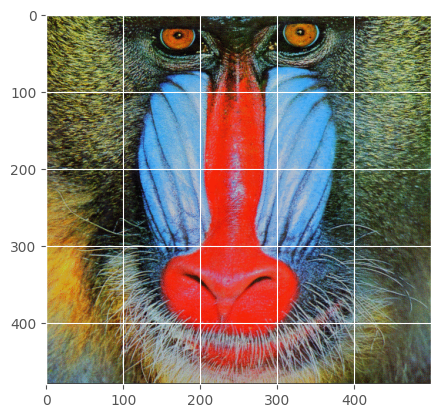

In [10]:

def imshow(img):
    img = img.numpy().transpose((1,2,0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

#images = next(iter(train_loader))
images = next(iter(valid_loader))

imshow(images[1][0])

# Network Definition


In [11]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Load a pretrained ResNet model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

class ResNetSRCNN(nn.Module):
    def __init__(self):
        super(ResNetSRCNN, self).__init__()
        
        # Use only the initial layers of ResNet without downsampling
        self.resnet_layers = nn.Sequential(
            resnet.conv1,  # First convolutional layer
            resnet.bn1,    # Batch normalization
            resnet.relu,   # Activation
            resnet.layer1  # First residual block (without downsampling)
        )
        
        # Freeze the ResNet layers
        for param in self.resnet_layers.parameters():
            param.requires_grad = False
        
        # SRCNN-inspired layers for feature extraction and reconstruction
        self.reconstruction = nn.Sequential(
            nn.ConvTranspose2d(64,64,kernel_size=4,stride=2,padding=1), # Upscaling to keep input and output size the same
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Keep the spatial size same
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),   # Output RGB channels
        )

    def forward(self, x):
        # Feature extraction (ResNet initial layers)
        features = self.resnet_layers(x)
        
        # Reconstruction (SRCNN-inspired layers)
        x = self.reconstruction(features)
        
        return x

In [12]:
# Create the model
resNetSRCNN = ResNetSRCNN()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resNetSRCNN = resNetSRCNN.to(device)

# Example forward pass with a dummy input
dummy_input = torch.randn(1, 3, 18,18).to(device)

resnet_output = resNetSRCNN.resnet_layers(dummy_input)
output = resNetSRCNN(dummy_input)

# Output shape should match the input shape
print(f"Input shape: {dummy_input.shape}")
print(f"ResNet output shape: {resnet_output.shape}")
print(f"Final output shape: {output.shape}")
#print(resNetSRCNN)

Input shape: torch.Size([1, 3, 18, 18])
ResNet output shape: torch.Size([1, 64, 9, 9])
Final output shape: torch.Size([1, 3, 18, 18])


# Training


In [15]:
import torch
import time
import torch.optim as optim
import torch.nn as nn
import os
from tqdm import tqdm
import copy

torch.cuda.is_available()

# Constants
TRAIN_LABEL_PATHS = 'input/t91_hr_patches'
TRAN_IMAGE_PATHS = 'input/t91_lr_patches'
VALID_LABEL_PATHS = 'input/test_hr'
VALID_IMAGE_PATHS = 'input/test_bicubic_rgb_2x'
SAVE_VALIDATION_RESULTS = True

dataset_train, dataset_valid = get_datasets(
    TRAN_IMAGE_PATHS, TRAIN_LABEL_PATHS,
    VALID_IMAGE_PATHS, VALID_LABEL_PATHS
)
train_loader, valid_loader = get_dataloaders(dataset_train, dataset_valid)

print(f"Training samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_valid)}")


Training samples: 22227
Validation samples: 19


In [16]:

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# Generic function to train a model
def train_model(model, criterion, optimizer=None, scheduler=None, num_epochs=10):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_psnr = 0.0

    train_loss, val_loss = [], []
    train_psnr, val_psnr = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_loader

            running_loss = 0.0
            running_psnr = 0.0

            # Iterate over data.
            for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs = data[0].to(device)
                labels = data[1].to(device)

                # zero the parameter gradients
                if(optimizer is not None):
                    optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs_denorm = denormalize(outputs)
                    loss = criterion(outputs_denorm, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_psnr += psnr(labels, outputs_denorm)

            epoch_loss = running_loss /len(dataloader)
            epoch_psnr = running_psnr /len(dataloader)

            print('{} Loss: {:.4f} PSNR: {:.4f}'.format(
                phase, epoch_loss, epoch_psnr))

            # deep copy the model
            if phase == 'val' and epoch_psnr > best_psnr:
                best_psnr = epoch_psnr
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == "train":
                train_loss.append(epoch_loss)
                train_psnr.append(epoch_psnr)
            
            if phase == "val":
                val_loss.append(epoch_loss)
                val_psnr.append(epoch_psnr)
            
        # save state and plots every 10 epochs
        if(epoch+1)%10==0 or epoch == num_epochs-1:
            save_model_state(model)
            save_plot(train_loss, val_loss, train_psnr, val_psnr)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val PSNR: {:4f}'.format(best_psnr))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNetSRCNN().to(device)
epochs = 10
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

model = train_model(model, criterion, optimizer,scheduler=None,num_epochs=epochs)

Epoch 0/9
----------


  0%|          | 0/174 [00:00<?, ?it/s]

100%|██████████| 174/174 [00:26<00:00,  6.59it/s]


train Loss: 0.0179 PSNR: 18.6397


100%|██████████| 19/19 [00:00<00:00, 24.07it/s]


val Loss: 0.0045 PSNR: 23.8446

Epoch 1/9
----------


100%|██████████| 174/174 [00:26<00:00,  6.66it/s]


train Loss: 0.0058 PSNR: 22.5191


100%|██████████| 19/19 [00:00<00:00, 27.77it/s]


val Loss: 0.0049 PSNR: 23.3953

Epoch 2/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.81it/s]


train Loss: 0.0045 PSNR: 23.5536


100%|██████████| 19/19 [00:00<00:00, 26.69it/s]


val Loss: 0.0032 PSNR: 25.3408

Epoch 3/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.81it/s]


train Loss: 0.0040 PSNR: 24.0806


100%|██████████| 19/19 [00:00<00:00, 28.06it/s]


val Loss: 0.0028 PSNR: 25.9351

Epoch 4/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.85it/s]


train Loss: 0.0035 PSNR: 24.6953


100%|██████████| 19/19 [00:00<00:00, 26.43it/s]


val Loss: 0.0049 PSNR: 23.3096

Epoch 5/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.95it/s]


train Loss: 0.0034 PSNR: 24.8562


100%|██████████| 19/19 [00:00<00:00, 28.68it/s]


val Loss: 0.0027 PSNR: 26.1513

Epoch 6/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.90it/s]


train Loss: 0.0031 PSNR: 25.1799


100%|██████████| 19/19 [00:00<00:00, 25.91it/s]


val Loss: 0.0024 PSNR: 26.6841

Epoch 7/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.82it/s]


train Loss: 0.0032 PSNR: 25.2454


100%|██████████| 19/19 [00:00<00:00, 29.42it/s]


val Loss: 0.0027 PSNR: 26.2295

Epoch 8/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.71it/s]


train Loss: 0.0030 PSNR: 25.4728


100%|██████████| 19/19 [00:00<00:00, 26.53it/s]


val Loss: 0.0026 PSNR: 26.2983

Epoch 9/9
----------


100%|██████████| 174/174 [00:25<00:00,  6.88it/s]


train Loss: 0.0027 PSNR: 25.8480


100%|██████████| 19/19 [00:00<00:00, 28.87it/s]


val Loss: 0.0027 PSNR: 26.1900
Saving model state...
Saving loss plots...
Saving PSNR plots...

Training complete in 4m 24s
Best val PSNR: 26.684054


# Testing


Test loading and upscaling a single image.


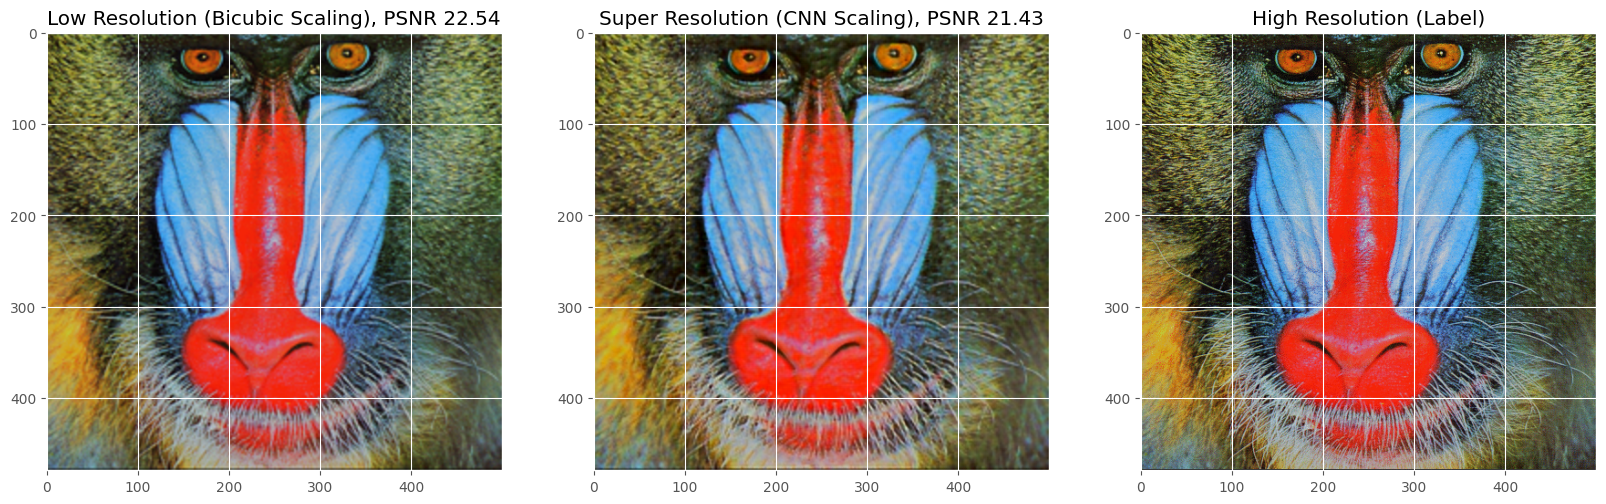

In [18]:
train_images = next(iter(train_loader))
valid_images = next(iter(valid_loader))

with torch.no_grad():
    lr_image = denormalize(valid_images[0]).to(device)
    hr_image = valid_images[1].to(device)
    sr_image = denormalize(model(valid_images[0].to(device)))

    lr_psnr = psnr(hr_image,lr_image)
    sr_psnr = psnr(sr_image,hr_image)

lr_image = lr_image.cpu()[0].numpy().transpose((1,2,0))
hr_image = hr_image.cpu()[0].numpy().transpose((1,2,0))
sr_image = sr_image.cpu()[0].numpy().transpose((1,2,0))

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title(f"Low Resolution (Bicubic Scaling), PSNR {lr_psnr:.2f}")
plt.imshow(lr_image)
plt.subplot(1,3,2)
plt.title(f"Super Resolution (CNN Scaling), PSNR {sr_psnr:.2f}")
plt.imshow(sr_image)
plt.subplot(1,3,3)
plt.title("High Resolution (Label)")
plt.imshow(hr_image)
plt.show()

Test sets of images


In [19]:
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            
            outputs = denormalize(outputs)
            
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr


# The SRCNN dataset module.
class TestDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]

        # rescale if uneven
        new_w = w if w % 2 == 0 else w-1
        new_h = h if h % 2 == 0 else h-1
        if new_w != w or new_h != h:
            w = new_w
            h = new_h
            label = label.resize((w,h), Image.BICUBIC)
        
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)


        image /= 255.
        label /= 255.

        # normalize lr image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225]) 
        image = (image - mean)/std

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_test_datasets(
    image_paths
):
    dataset_test = TestDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_test_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader

In [20]:
# Load the model.
model = ResNetSRCNN().to(device)
model.load_state_dict(torch.load('outputs/model.pth'))
data_paths = [
    ['input/Set5/original', 'Set5'],
    ['input/Set14/original', 'Set14']
]
for data_path in data_paths:
    dataset_test = get_test_datasets(data_path[0])
    test_loader = get_test_dataloaders(dataset_test)
    _, test_psnr = validate(model, test_loader, device)
    print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

C:\Users\bkoss\AppData\Local\Temp\ipykernel_36672\2184922708.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('outputs/model.pth'))
100%|

Test PSNR on Set5: 27.485


100%|██████████| 14/14 [00:00<00:00, 25.95it/s]

Test PSNR on Set14: 25.724
